## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import cv2
from tqdm import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121, ResNet50V2, EfficientNetB0, InceptionV3, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD

2025-04-12 23:57:45.784892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744502265.976010      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744502266.032362      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_path ='/kaggle/input/pharmaceutical-drugs-and-vitamins-synthetic-images/Drug Vision/Data Combined'
os.listdir(data_path)

['DayZinc',
 'Alaxan',
 'Decolgen',
 'Bactidol',
 'Medicol',
 'Kremil S',
 'Biogesic',
 'Neozep',
 'Fish Oil',
 'Bioflu']

In [3]:
labels = ['DayZinc',
 'Alaxan',
 'Decolgen',
 'Bactidol',
 'Medicol',
 'Kremil S',
 'Biogesic',
 'Neozep',
 'Fish Oil',
 'Bioflu']

DayZinc : Class number 0 , that contain 1000 image


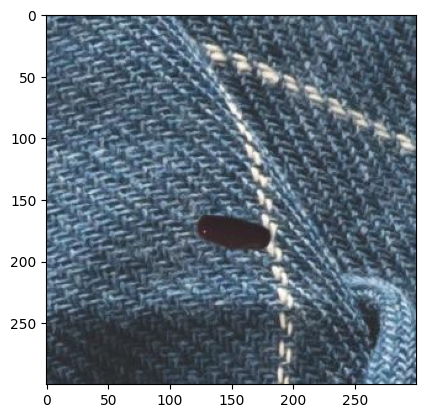

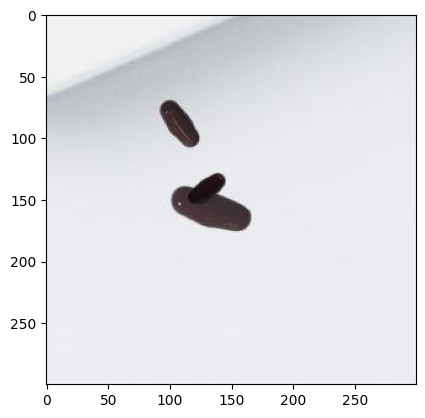

Alaxan : Class number 1 , that contain 1000 image


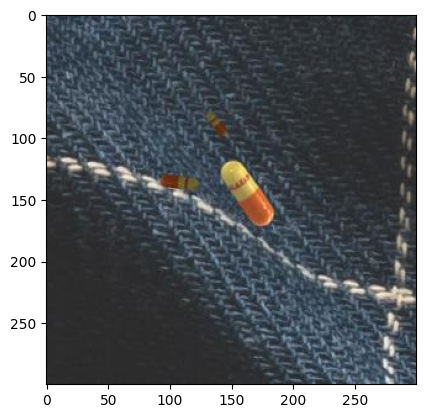

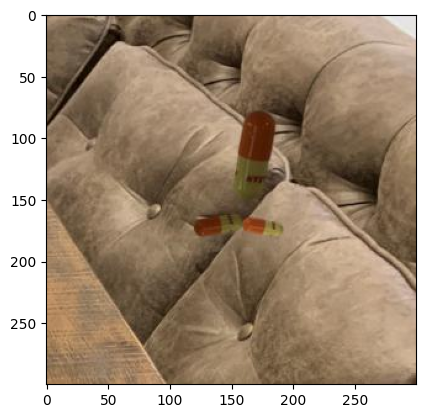

Decolgen : Class number 2 , that contain 1000 image


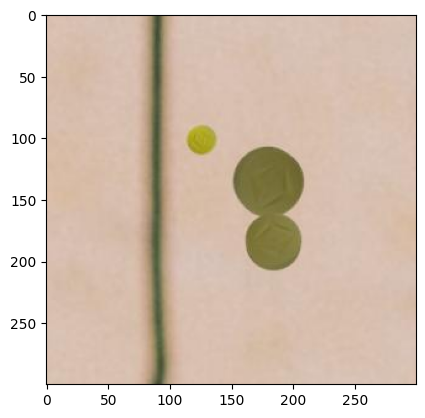

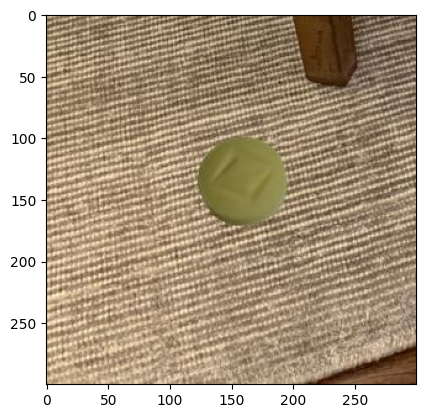

Bactidol : Class number 3 , that contain 1000 image


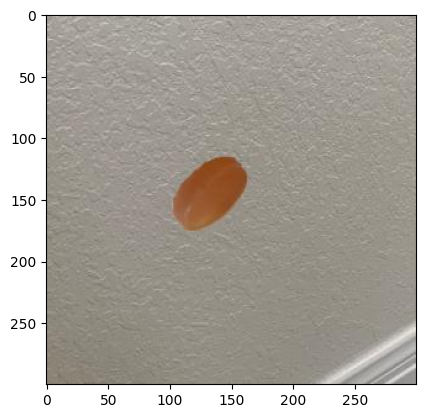

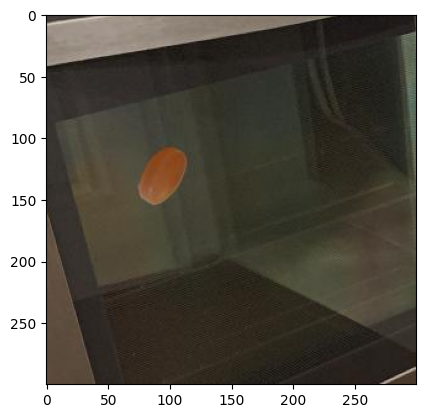

Medicol : Class number 4 , that contain 1000 image


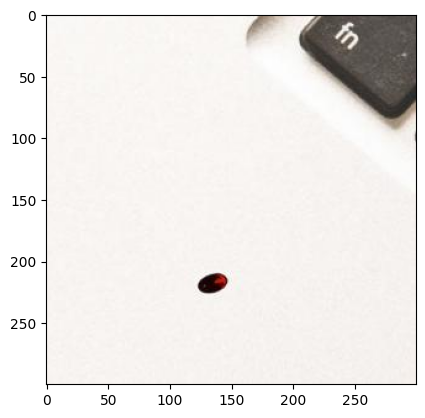

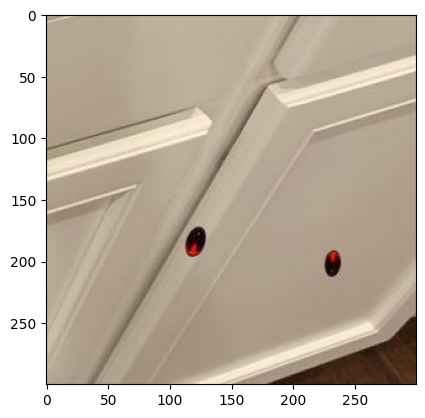

Kremil S : Class number 5 , that contain 1000 image


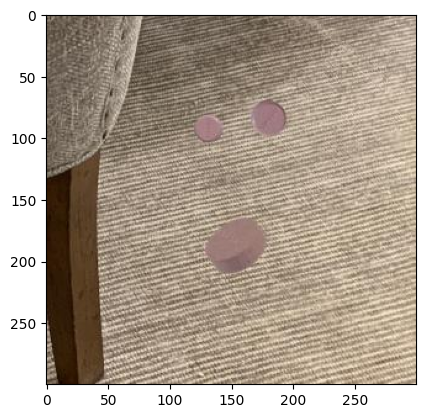

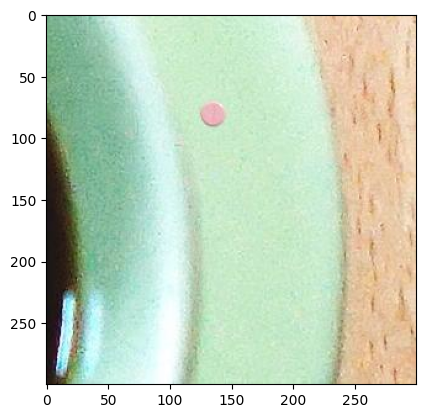

Biogesic : Class number 6 , that contain 1000 image


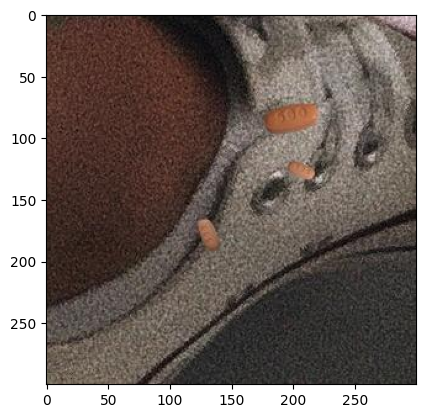

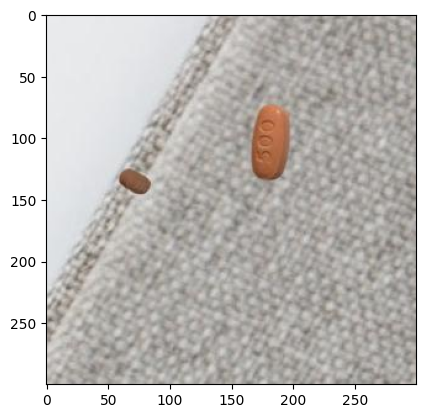

Neozep : Class number 7 , that contain 1000 image


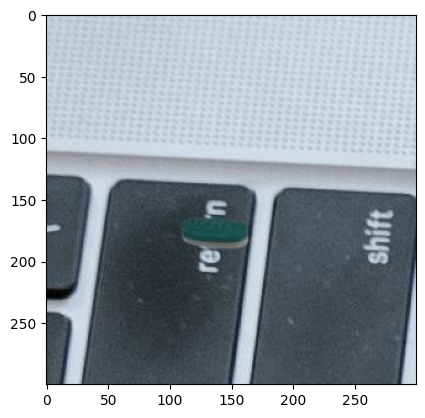

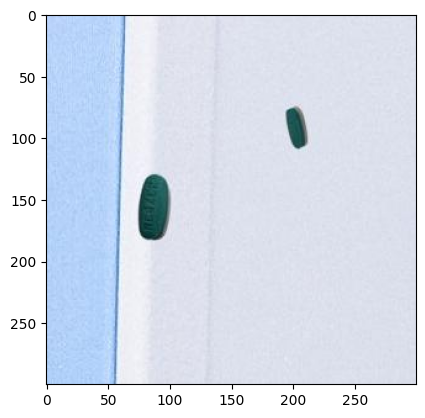

Fish Oil : Class number 8 , that contain 1000 image


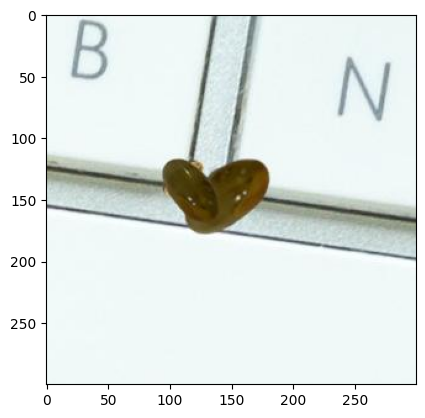

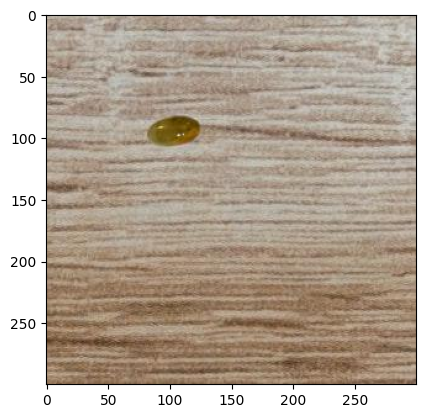

Bioflu : Class number 9 , that contain 1000 image


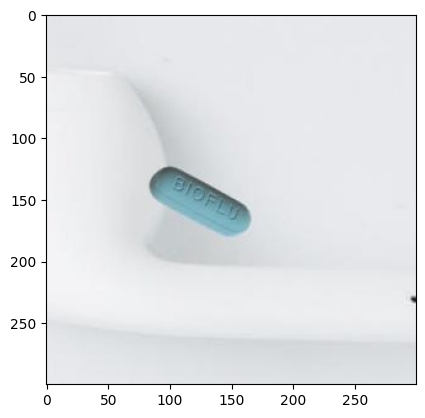

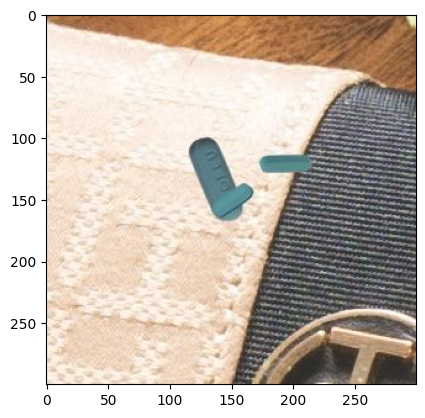

In [4]:
i =0
counts = {}

for label in labels :
    path =os.path.join(data_path ,label)
    counts[label] = len(os.listdir(path))
    x =0
    print(f'{label} : Class number {i} , that contain {len(os.listdir(path))} image')
    for img in os.listdir(path):
        x +=1
        img =cv2.imread(os.path.join(path ,img) ,cv2.IMREAD_COLOR_RGB)
        plt.imshow(img)
        plt.show()
        if x ==2 :
            print('=='*40)
            break
    i +=1

- Check if the data balanced or not

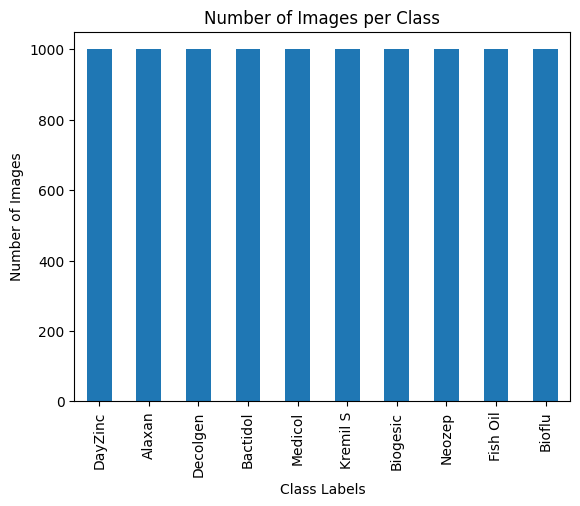

In [5]:
df = pd.DataFrame(list(counts.items()), columns=['Label', 'Count'])
df.set_index('Label', inplace=True)


df.plot(kind='bar', legend=False)

plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.show()

In [6]:
img.shape

(300, 300, 3)

In [7]:
img.max(), img.min()

(255, 19)

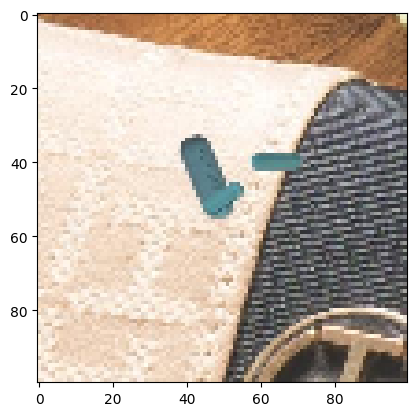

In [8]:
img_size =100

resized_img =cv2.resize(img ,(img_size ,img_size) ,3)
plt.imshow(resized_img)
plt.show()

## Preprocessing

In this phase i:
- split data into train 80% val 10% test 10%
- Do ImageDataGenerator to make:
   - `Data Augmentation` (Artificially expanding the dataset)

   - `Efficient Memory Usage` (Loading images in batches instead of all at once)

   - `Preprocessing & Normalization` (Scaling pixel values, resizing, etc.)

   - `Automatic Label Handling` (Matching images to their classes)

In [9]:
img_size = 100  
target_size = (img_size, img_size)
batch_size =64

# Get all image paths and labels
image_paths = []
labels = []

for class_name in os.listdir(data_path):
    class_dir = os.path.join(data_path, class_name)
    for img_name in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_name))
        labels.append(class_name)

# Convert to numpy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

# First split: 80% train, 20% temp (val + test)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)

# Second split: 10% val, 10% test
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=42
)

# Now create generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)



train_df = pd.DataFrame({'filename': train_paths, 'class': train_labels})
val_df = pd.DataFrame({'filename': val_paths, 'class': val_labels})
test_df = pd.DataFrame({'filename': test_paths, 'class': test_labels})



# Create generators with corrected target_size
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)

validation_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    target_size=target_size,  
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

Found 8000 validated image filenames belonging to 10 classes.
Found 1000 validated image filenames belonging to 10 classes.
Found 1000 validated image filenames belonging to 10 classes.


In [10]:
class_indices = train_generator.class_indices
class_indices

{'Alaxan': 0,
 'Bactidol': 1,
 'Bioflu': 2,
 'Biogesic': 3,
 'DayZinc': 4,
 'Decolgen': 5,
 'Fish Oil': 6,
 'Kremil S': 7,
 'Medicol': 8,
 'Neozep': 9}

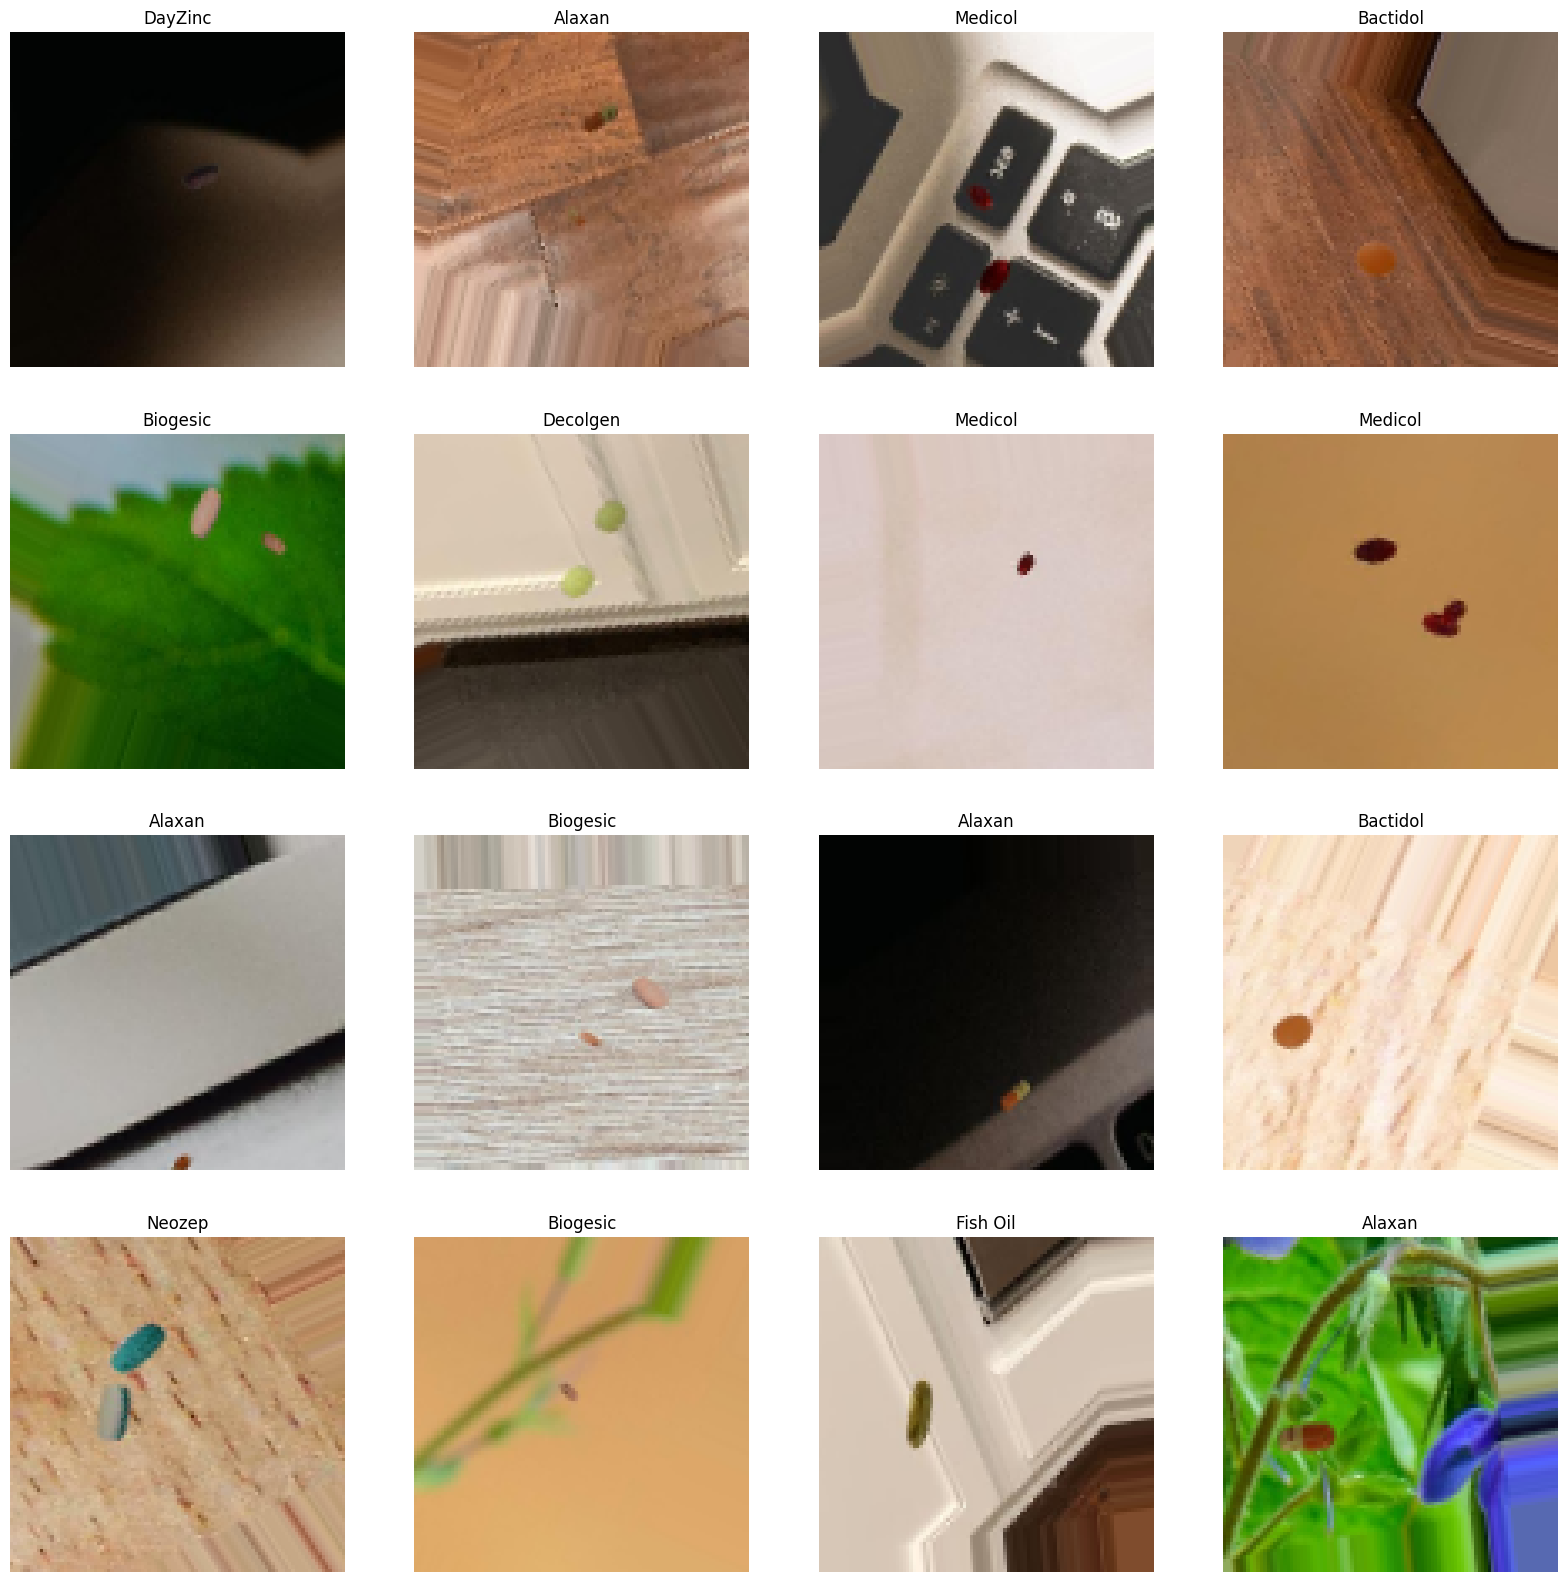

In [11]:
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(20, 20))
for X_batch, y_batch in train_generator:
    # Convert float32 labels to integers
    y_batch_int = y_batch.astype(int)  # Fix: Convert to int
    
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(X_batch[i])
        plt.title(class_names[y_batch_int[i]])  # Use integer index
        plt.axis('off')
        plt.grid(False)
    plt.show()
    break  # Only show the first batch

## Simple CNN model

In [12]:
# Define input shape (height, width, channels)
input_shape = (img_size, img_size, 3)  
num_classes = len(labels)

# Build the model
CNN_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

# Compile the model
CNN_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Print model summary
CNN_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1744502308.630860      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 98, 98, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 47, 47, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 20, 20, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 18, 18, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 7, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 7, 7, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 5, 5, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,587,920 (9.87 MB)

 Trainable params: 2,586,064 (9.87 MB)

 Non-trainable params: 1,856 (7.25 KB)

In [13]:
history_CNN = CNN_model.fit(train_generator,
                    epochs = 100,
                    validation_data = validation_generator,
                    callbacks = early_stopping
                    )

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744502320.985041      61 service.cc:148] XLA service 0x7ff2e810a400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744502320.985921      61 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744502321.739402      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/125 ━━━━━━━━━━━━━━━━━━━━ 37:57 18s/step - accuracy: 0.0000e+00 - loss: 9.4301

I0000 00:00:1744502329.084424      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 462ms/step - accuracy: 0.0565 - loss: 7.3443 - val_accuracy: 0.0870 - val_loss: 6.0170
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 216ms/step - accuracy: 0.1265 - loss: 2.4877 - val_accuracy: 0.0880 - val_loss: 3.1538
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 217ms/step - accuracy: 0.1673 - loss: 2.3056 - val_accuracy: 0.1150 - val_loss: 2.7170
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 218ms/step - accuracy: 0.2025 - loss: 2.1596 - val_accuracy: 0.1470 - val_loss: 2.6671
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 215ms/step - accuracy: 0.2618 - loss: 2.0090 - val_accuracy: 0.2070 - val_loss: 2.1450
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 222ms/step - accuracy: 0.3010 - loss: 1.9185 - val_accuracy: 0.3850 - val_loss: 1.7439
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 215ms/step - accuracy: 0.3616 - loss: 1.7532 - val_accuracy: 0.3870 - val_loss: 1.7045
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 219ms/step - accuracy: 0.4207 - loss: 1.614

- Save model

In [14]:
CNN_model.save('CNN_Drugs.h5')

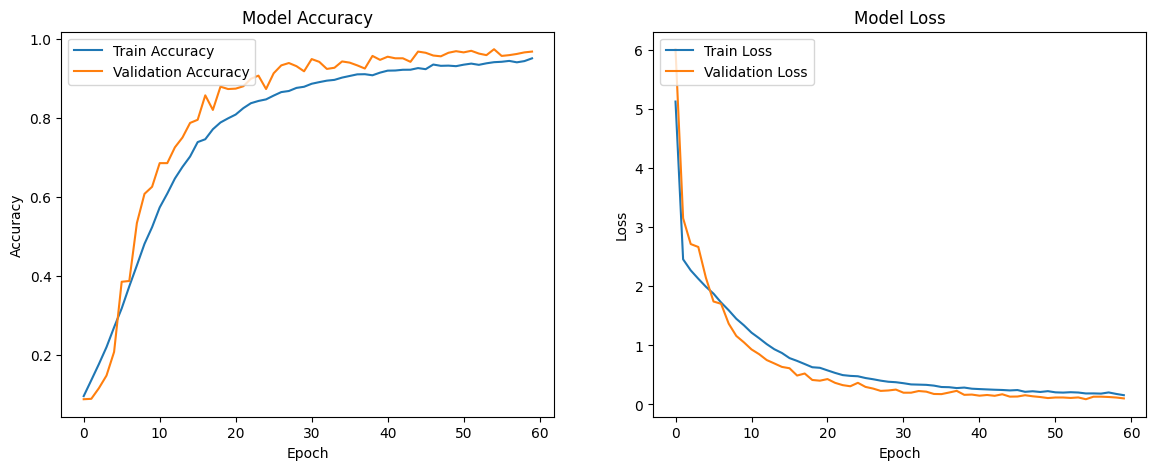

In [15]:
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_CNN.history['accuracy'], label='Train Accuracy')
plt.plot(history_CNN.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_CNN.history['loss'], label='Train Loss')
plt.plot(history_CNN.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

In [16]:
test_loss, test_acc = CNN_model.evaluate(test_generator)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 341ms/step - accuracy: 0.9683 - loss: 0.1508
Test accuracy: 0.968999981880188
Test loss: 0.14474035799503326


- **Confusion Matrix**

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step


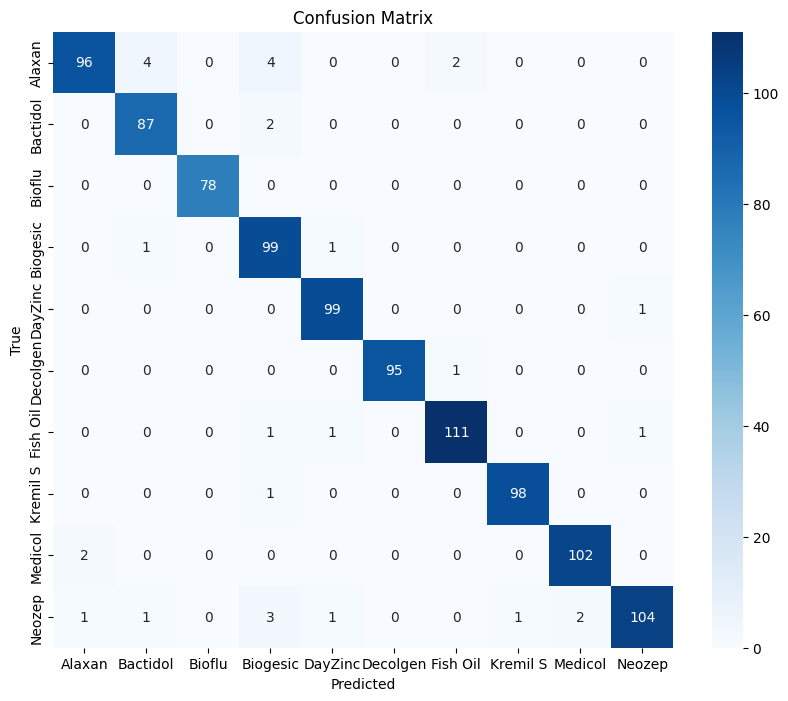

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get true labels from test generator
y_true = test_generator.classes

# Get predicted probabilities
y_pred_probs = CNN_model.predict(test_generator)

# Convert to class predictions (from probabilities)
y_pred = np.argmax(y_pred_probs, axis=1)


# Get class names
class_names = list(test_generator.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

- **Classification Report**

In [18]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


              precision    recall  f1-score   support

      Alaxan       0.97      0.91      0.94       106
    Bactidol       0.94      0.98      0.96        89
      Bioflu       1.00      1.00      1.00        78
    Biogesic       0.90      0.98      0.94       101
     DayZinc       0.97      0.99      0.98       100
    Decolgen       1.00      0.99      0.99        96
    Fish Oil       0.97      0.97      0.97       114
    Kremil S       0.99      0.99      0.99        99
     Medicol       0.98      0.98      0.98       104
      Neozep       0.98      0.92      0.95       113

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



- Show some images and model prediction

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


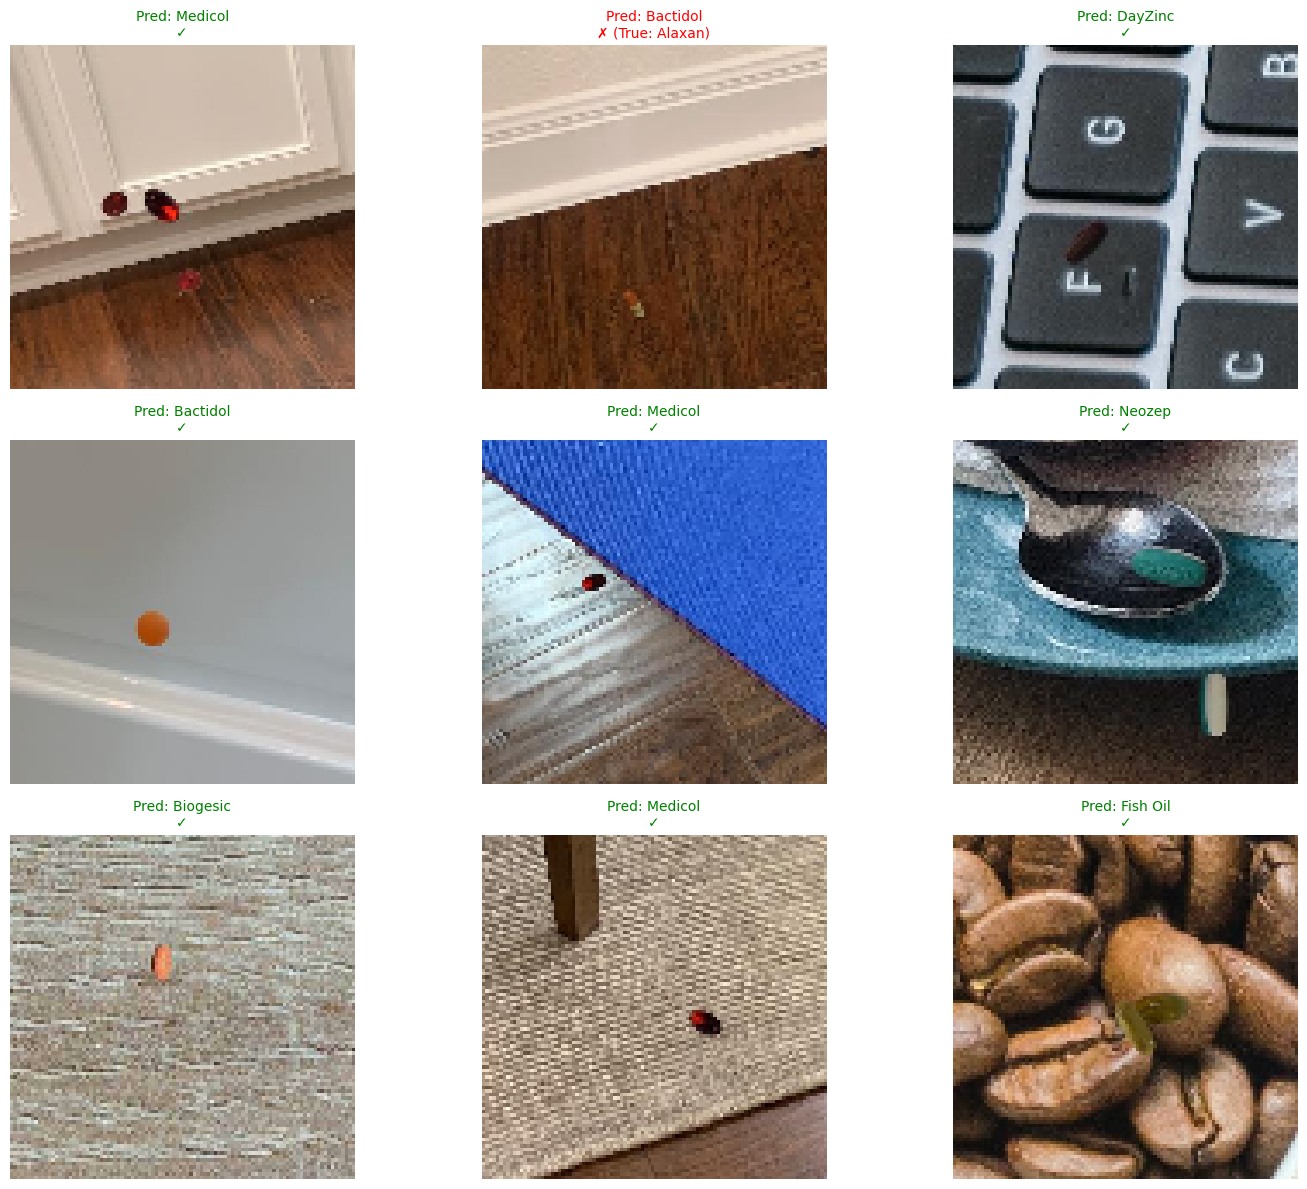

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img

# Get a batch from test generator
test_images, test_labels = next(test_generator)  

# Predict (assuming model outputs probabilities)
predictions = CNN_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)  # For multi-class

# Get class names (replace with your actual classes)
class_names = list(test_generator.class_indices.keys()) 

# Display 9 images with predictions
plt.figure(figsize=(15, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    
    # Convert normalized image back to [0,255] for display
    img = array_to_img(test_images[i]) 
    
    plt.imshow(img)
    
    true_class = class_names[int(test_labels[i])]
    pred_class = class_names[predicted_labels[i]]
    
    correctness = "✓" if true_class == pred_class else f"✗ (True: {true_class})"
    title_color = 'green' if true_class == pred_class else 'red'
    
    plt.title(f"Pred: {pred_class}\n{correctness}", 
              color=title_color, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()